In [1]:
# =============================================================================
# 1. SETUP AND DATA LOADING
# =============================================================================

# Install required packages (uncomment if needed)
!pip install xgboost lightgbm imbalanced-learn optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
import os

# Mount Google Drive and load data
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CTU13')

# Load dataset
print("Loading dataset...")
data = pd.read_csv('Data.txt', sep=',')
print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print("\nFirst few rows:")
print(data.head())

# Basic data info
print("\nDataset Info:")
print(data.info())
print("\nMissing values:")
print(data.isnull().sum())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 25.6 MB/s eta 0:00:00
Mounted at /content/drive
Loading dataset...
Dataset shape: (2824636, 15)
Columns: ['StartTime', 'Dur', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes', 'Label']

First few rows:
                    StartTime          Dur Proto        SrcAddr  Sport    Dir  \
0  2011/08/10 09:46:53.047277  3550.


EXPLORATORY DATA ANALYSIS

Label distribution:
Label
flow=Background-UDP-Established                                            1169677
flow=To-Background-UDP-CVUT-DNS-Server                                      941706
flow=Background-TCP-Established                                             223543
flow=Background-Established-cmpgw-CVUT                                      137257
flow=Background-TCP-Attempt                                                 105438
                                                                            ...   
flow=From-Botnet-V42-TCP-Established-HTTP-Adobe-4                                1
flow=From-Botnet-V42-TCP-Established-HTTP-Binary-Download-Custom-Port-5          1
flow=From-Botnet-V42-TCP-HTTP-Not-Encrypted-Down-2                               1
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-60                                  1
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-49                                  1
Name: count, Length: 113, dtype: 

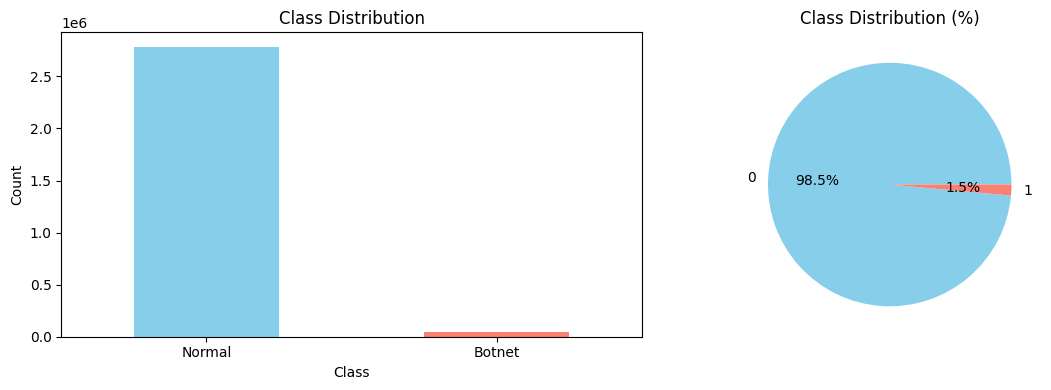

In [2]:
# =============================================================================
# 2. EXPLORATORY DATA ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Label distribution
print("\nLabel distribution:")
print(data['Label'].value_counts())

# Create binary labels
data['IsBotnet'] = data['Label'].str.contains('Botnet', case=False, na=False).astype(int)
print(f"\nBinary label distribution:")
print(f"Normal traffic: {(data['IsBotnet'] == 0).sum():,}")
print(f"Botnet traffic: {(data['IsBotnet'] == 1).sum():,}")
print(f"Imbalance ratio: {(data['IsBotnet'] == 0).sum() / (data['IsBotnet'] == 1).sum():.2f}:1")

# Visualization of class distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
data['IsBotnet'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal', 'Botnet'], rotation=0)

plt.subplot(1, 2, 2)
data['IsBotnet'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Class Distribution (%)')
plt.ylabel('')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [3]:
# =============================================================================
# 3. ADVANCED DATA PREPROCESSING
# =============================================================================

print("\n" + "="*50)
print("ADVANCED DATA PREPROCESSING")
print("="*50)

# Convert StartTime to datetime
data['StartTime'] = pd.to_datetime(data['StartTime'])

# Extract time-based features
data['Hour'] = data['StartTime'].dt.hour
data['Minute'] = data['StartTime'].dt.minute
data['Second'] = data['StartTime'].dt.second
data['DayOfWeek'] = data['StartTime'].dt.dayofweek
data['Is_weekend'] = data['DayOfWeek'].isin([5, 6]).astype(int)
data['Is_night'] = ((data['Hour'] >= 22) | (data['Hour'] <= 6)).astype(int)
data['Is_business_hours'] = ((data['Hour'] >= 9) & (data['Hour'] <= 17)).astype(int)

# Handle missing values
print("Handling missing values...")
data['sTos'] = data['sTos'].fillna(0)
data['dTos'] = data['dTos'].fillna(0)
data['Sport'] = data['Sport'].fillna('Unknown')
data['Dport'] = data['Dport'].fillna('Unknown')
data['State'] = data['State'].fillna(data['State'].mode()[0])

# Advanced feature engineering
print("Creating advanced features...")

def create_advanced_features(df):
    """Create sophisticated network traffic features"""

    # Network flow patterns
    df['Packet_rate'] = df['TotPkts'] / (df['Dur'] + 1e-6)
    df['Byte_rate'] = df['TotBytes'] / (df['Dur'] + 1e-6)
    df['Avg_packet_size'] = df['TotBytes'] / (df['TotPkts'] + 1)
    df['Bytes_per_packet'] = df['TotBytes'] / (df['TotPkts'] + 1)
    df['Bytes_ratio'] = df['SrcBytes'] / (df['TotBytes'] + 1)

    # Connection patterns
    df['Is_bidirectional'] = (df['Dir'] == '<->').astype(int)
    df['Is_short_connection'] = (df['Dur'] < 0.1).astype(int)
    df['Is_long_connection'] = (df['Dur'] > 10).astype(int)
    df['Is_high_volume'] = (df['TotBytes'] > df['TotBytes'].quantile(0.95)).astype(int)
    df['Is_high_packet_count'] = (df['TotPkts'] > df['TotPkts'].quantile(0.95)).astype(int)

    # Protocol analysis
    df['Is_TCP'] = (df['Proto'] == 'tcp').astype(int)
    df['Is_UDP'] = (df['Proto'] == 'udp').astype(int)
    df['Is_ICMP'] = (df['Proto'] == 'icmp').astype(int)

    # Port categorization
    def categorize_port(port):
        try:
            port_num = int(port)
            if port_num <= 1023: return 'well_known'
            elif port_num <= 49151: return 'registered'
            else: return 'dynamic'
        except: return 'unknown'

    df['Sport_category'] = df['Sport'].apply(categorize_port)
    df['Dport_category'] = df['Dport'].apply(categorize_port)

    # Common ports analysis
    common_ports = [21, 22, 23, 25, 53, 80, 110, 143, 443, 993, 995]
    df['Uses_common_sport'] = df['Sport'].apply(
        lambda x: int(str(x)) in common_ports if str(x).isdigit() else 0
    )
    df['Uses_common_dport'] = df['Dport'].apply(
        lambda x: int(str(x)) in common_ports if str(x).isdigit() else 0
    )

    # Duration categorization
    df['Duration_category'] = pd.cut(df['Dur'],
                                    bins=[0, 0.001, 0.1, 1, 10, 100, float('inf')],
                                    labels=['very_short', 'short', 'medium', 'long', 'very_long', 'extremely_long'],
                                    include_lowest=True).cat.add_categories('unknown').fillna('unknown')

    # Statistical features based on TOS
    df['TOS_entropy'] = -((df['sTos'] + 1) * np.log(df['sTos'] + 1) +
                         (df['dTos'] + 1) * np.log(df['dTos'] + 1))
    df['TOS_diff'] = abs(df['sTos'] - df['dTos'])

    # Flow efficiency metrics
    df['Efficiency'] = df['SrcBytes'] / (df['TotBytes'] + 1)
    df['Packet_size_variance'] = abs(df['Avg_packet_size'] - df['Avg_packet_size'].median())

    return df

# Apply feature engineering
data = create_advanced_features(data)

print(f"Dataset shape after feature engineering: {data.shape}")
print("New features created successfully!")



ADVANCED DATA PREPROCESSING
Handling missing values...
Creating advanced features...
Dataset shape after feature engineering: (2824636, 45)
New features created successfully!


In [4]:
# =============================================================================
# 4. FEATURE SELECTION AND PREPARATION
# =============================================================================

print("\n" + "="*50)
print("FEATURE SELECTION AND PREPARATION")
print("="*50)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Define feature sets
numerical_features = [
    'Dur', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes',
    'Hour', 'Minute', 'Second', 'DayOfWeek',
    'Packet_rate', 'Byte_rate', 'Avg_packet_size', 'Bytes_per_packet', 'Bytes_ratio',
    'TOS_entropy', 'TOS_diff', 'Efficiency', 'Packet_size_variance'
]

categorical_features = [
    'Proto', 'Dir', 'State', 'Sport_category', 'Dport_category', 'Duration_category'
]

binary_features = [
    'Is_weekend', 'Is_night', 'Is_business_hours', 'Is_bidirectional',
    'Is_short_connection', 'Is_long_connection', 'Is_high_volume', 'Is_high_packet_count',
    'Is_TCP', 'Is_UDP', 'Is_ICMP', 'Uses_common_sport', 'Uses_common_dport'
]

all_features = numerical_features + categorical_features + binary_features

# Create feature matrix
X = data[all_features].copy()
y = data['IsBotnet']

print(f"Total features: {len(all_features)}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Binary features: {len(binary_features)}")

# Encode categorical features
print("Encoding categorical features...")
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature].astype(str))
    label_encoders[feature] = le

# Handle infinite and NaN values
print("Cleaning data...")
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Split the data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set class distribution: {y_train.value_counts().values}")
print(f"Test set class distribution: {y_test.value_counts().values}")

# Feature scaling
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale numerical features only
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# Feature selection
print("Performing feature selection...")
selector = SelectKBest(score_func=f_classif, k=25)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X_train_scaled.columns[selector.get_support()]
print(f"Selected {len(selected_features)} most important features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1:2d}. {feature}")



FEATURE SELECTION AND PREPARATION
Total features: 38
Numerical features: 19
Categorical features: 6
Binary features: 13
Encoding categorical features...
Cleaning data...
Splitting data...
Training set shape: (2259708, 38)
Test set shape: (564928, 38)
Training set class distribution: [2226939   32769]
Test set class distribution: [556736   8192]
Scaling features...
Performing feature selection...
Selected 25 most important features:
 1. Dur
 2. Hour
 3. Minute
 4. Second
 5. Packet_rate
 6. Byte_rate
 7. Avg_packet_size
 8. Bytes_per_packet
 9. Bytes_ratio
10. Efficiency
11. Packet_size_variance
12. Dir
13. State
14. Sport_category
15. Dport_category
16. Duration_category
17. Is_short_connection
18. Is_long_connection
19. Is_high_volume
20. Is_high_packet_count
21. Is_TCP
22. Is_UDP
23. Is_ICMP
24. Uses_common_sport
25. Uses_common_dport


In [5]:
# =============================================================================
# 5. HANDLE CLASS IMBALANCE
# =============================================================================

print("\n" + "="*50)
print("HANDLING CLASS IMBALANCE")
print("="*50)

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

def apply_sampling_strategy(X_train, y_train, strategy='smote'):
    """Apply different sampling strategies"""
    print(f"Applying {strategy.upper()} sampling...")
    print(f"Original distribution: {np.bincount(y_train)}")

    if strategy == 'smote':
        sampler = SMOTE(random_state=42, k_neighbors=3)
    elif strategy == 'adasyn':
        sampler = ADASYN(random_state=42)
    elif strategy == 'smoteenn':
        sampler = SMOTEENN(random_state=42)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    print(f"Resampled distribution: {np.bincount(y_resampled)}")
    print(f"New dataset shape: {X_resampled.shape}")

    return X_resampled, y_resampled

# Apply SMOTE
X_train_resampled, y_train_resampled = apply_sampling_strategy(
    X_train_selected, y_train, 'smote'
)


HANDLING CLASS IMBALANCE
Applying SMOTE sampling...
Original distribution: [2226939   32769]
Resampled distribution: [2226939 2226939]
New dataset shape: (4453878, 25)


In [6]:
# =============================================================================
# 6. MODEL DEVELOPMENT AND ENSEMBLE
# =============================================================================

print("\n" + "="*50)
print("MODEL DEVELOPMENT")
print("="*50)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, average_precision_score,
                           precision_recall_curve, roc_curve)

# Individual model configurations
models = {
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    ),

    'LightGBM': LGBMClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    ),

    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),

    'LogisticRegression': LogisticRegression(
        C=1.0,
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        n_jobs=-1
    )
}

# Train individual models
print("Training individual models...")
trained_models = {}
individual_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    trained_models[name] = model

    # Predictions
    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

    # Metrics
    individual_results[name] = {
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'pr_auc': average_precision_score(y_test, y_pred_proba),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

    print(f"{name} - ROC-AUC: {individual_results[name]['roc_auc']:.4f}, "
          f"PR-AUC: {individual_results[name]['pr_auc']:.4f}")

# Create ensemble model
print("\nCreating ensemble model...")
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', trained_models['XGBoost']),
        ('lgb', trained_models['LightGBM']),
        ('rf', trained_models['RandomForest'])
    ],
    voting='soft'
)

ensemble_model.fit(X_train_resampled, y_train_resampled)
print("Ensemble model trained successfully!")



MODEL DEVELOPMENT
Training individual models...

Training XGBoost...
XGBoost - ROC-AUC: 0.9992, PR-AUC: 0.9604

Training LightGBM...
LightGBM - ROC-AUC: 0.9990, PR-AUC: 0.9505

Training RandomForest...
RandomForest - ROC-AUC: 0.9980, PR-AUC: 0.8983

Training LogisticRegression...
LogisticRegression - ROC-AUC: 0.9744, PR-AUC: 0.3464

Creating ensemble model...
Ensemble model trained successfully!


In [7]:
# =============================================================================
# 7. COMPREHENSIVE MODEL EVALUATION
# =============================================================================

print("\n" + "="*50)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*50)

def comprehensive_evaluation(model, X_test, y_test, model_name="Model"):
    """Perform comprehensive model evaluation"""

    print(f"\n{model_name} Evaluation:")
    print("-" * 40)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Botnet']))

    # ROC-AUC and PR-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")

    # Find optimal threshold using F1-score
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]

    print(f"Optimal Threshold (F1-based): {optimal_threshold:.4f}")
    print(f"F1-Score at optimal threshold: {f1_scores[optimal_idx]:.4f}")

    # Predictions with optimal threshold
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    print("\nClassification Report (Optimal Threshold):")
    print(classification_report(y_test, y_pred_optimal, target_names=['Normal', 'Botnet']))

    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'optimal_threshold': optimal_threshold,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'y_pred_optimal': y_pred_optimal
    }

# Evaluate ensemble model
ensemble_results = comprehensive_evaluation(ensemble_model, X_test_selected, y_test, "Ensemble")

# Compare all models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_data = []
for name in models.keys():
    comparison_data.append({
        'Model': name,
        'ROC-AUC': individual_results[name]['roc_auc'],
        'PR-AUC': individual_results[name]['pr_auc'],
        'F1-Score': individual_results[name]['classification_report']['1']['f1-score'],
        'Precision': individual_results[name]['classification_report']['1']['precision'],
        'Recall': individual_results[name]['classification_report']['1']['recall']
    })

comparison_data.append({
    'Model': 'Ensemble',
    'ROC-AUC': ensemble_results['roc_auc'],
    'PR-AUC': ensemble_results['pr_auc'],
    'F1-Score': classification_report(y_test, ensemble_results['y_pred'], output_dict=True)['1']['f1-score'],
    'Precision': classification_report(y_test, ensemble_results['y_pred'], output_dict=True)['1']['precision'],
    'Recall': classification_report(y_test, ensemble_results['y_pred'], output_dict=True)['1']['recall']
})

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))



COMPREHENSIVE MODEL EVALUATION

Ensemble Evaluation:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99    556736
      Botnet       0.52      0.99      0.69      8192

    accuracy                           0.99    564928
   macro avg       0.76      0.99      0.84    564928
weighted avg       0.99      0.99      0.99    564928

ROC-AUC Score: 0.9990
Precision-Recall AUC: 0.9499
Optimal Threshold (F1-based): 0.9444
F1-Score at optimal threshold: 0.8818

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    556736
      Botnet       0.88      0.88      0.88      8192

    accuracy                           1.00    564928
   macro avg       0.94      0.94      0.94    564928
weighted avg       1.00      1.00      1.00    564928


MODEL COMPARISON
                Model  ROC-AUC  PR-AUC  


CREATING VISUALIZATIONS


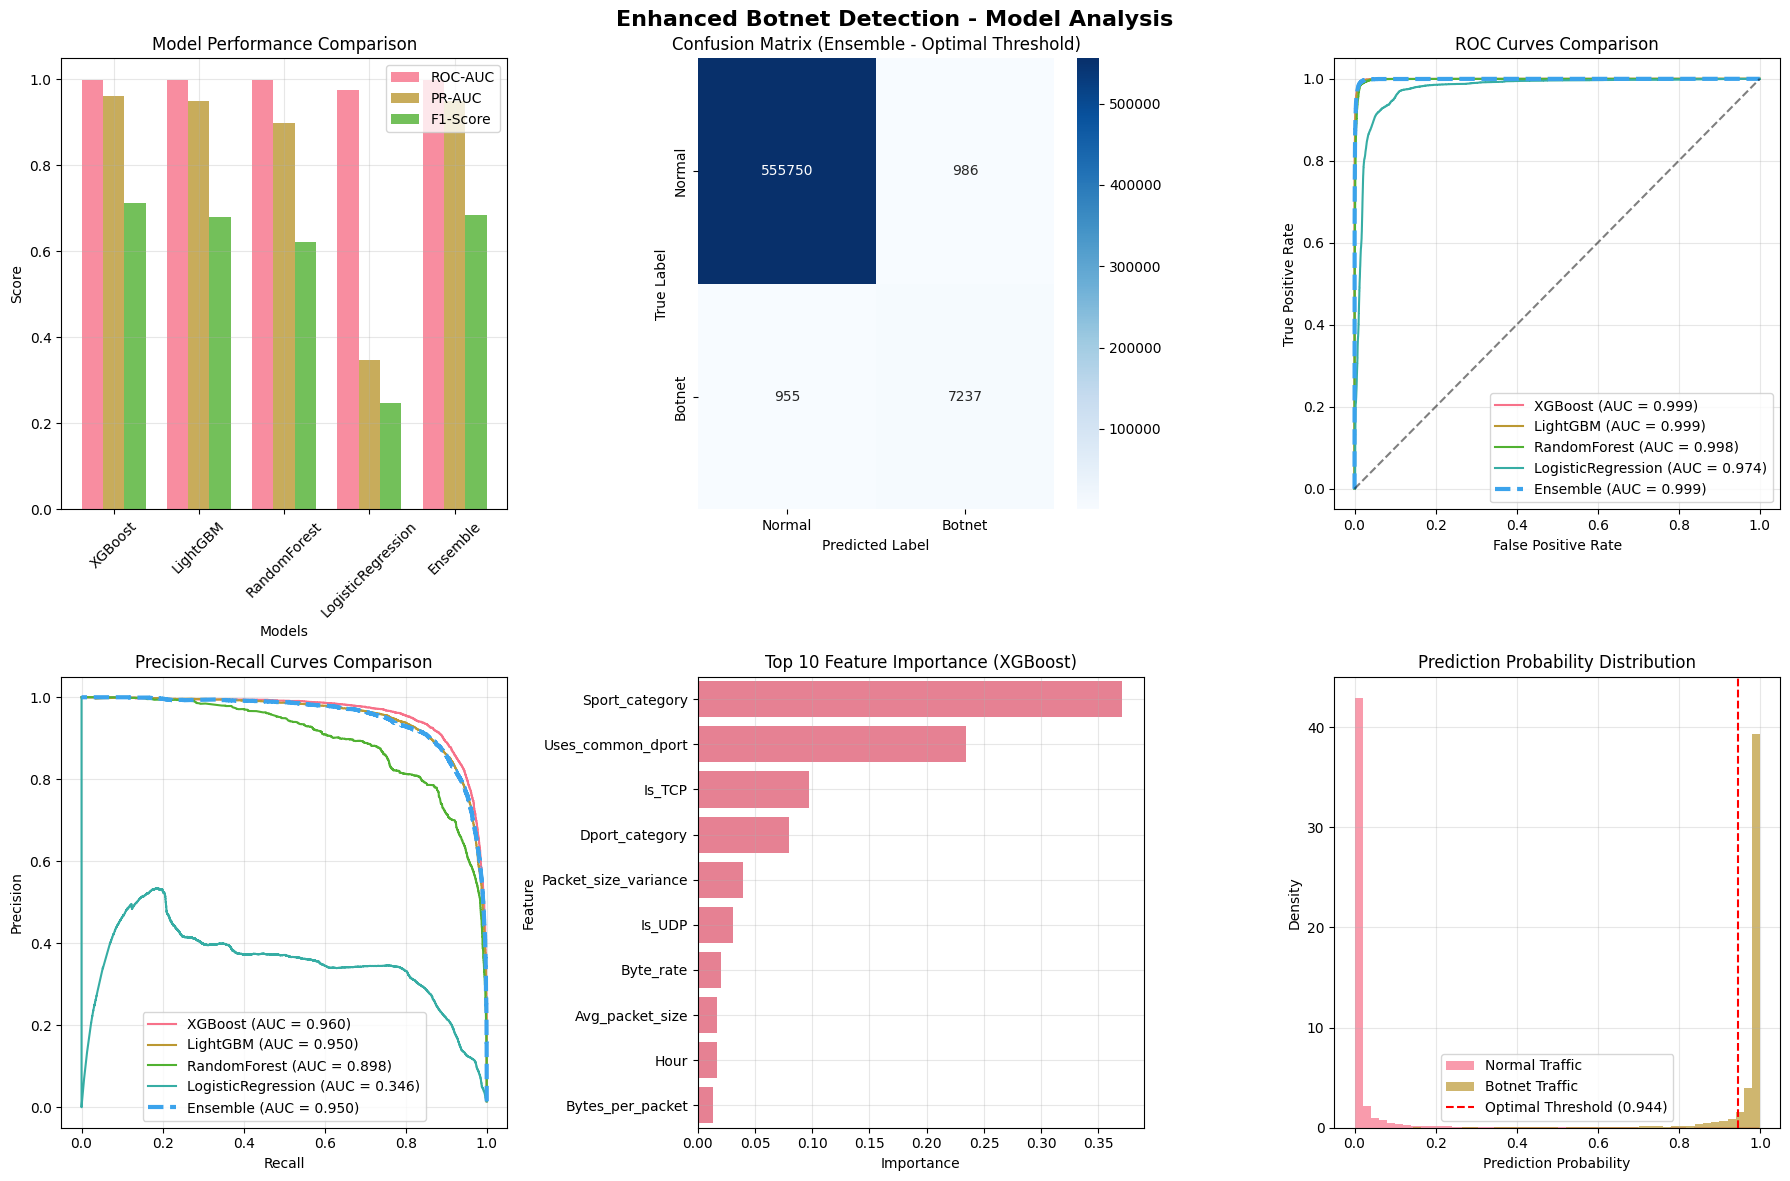

In [8]:
# =============================================================================
# 8. VISUALIZATION AND ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("CREATING VISUALIZATIONS")
print("="*50)

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Enhanced Botnet Detection - Model Analysis', fontsize=16, fontweight='bold')

# 1. Model Comparison Bar Plot
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison_df))
width = 0.25

ax1.bar(x_pos - width, comparison_df['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)
ax1.bar(x_pos, comparison_df['PR-AUC'], width, label='PR-AUC', alpha=0.8)
ax1.bar(x_pos + width, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Model'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Confusion Matrix for Ensemble
ax2 = axes[0, 1]
cm = confusion_matrix(y_test, ensemble_results['y_pred_optimal'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Normal', 'Botnet'], yticklabels=['Normal', 'Botnet'])
ax2.set_title('Confusion Matrix (Ensemble - Optimal Threshold)')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curves
ax3 = axes[0, 2]
for name, model in trained_models.items():
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, label=f'{name} (AUC = {individual_results[name]["roc_auc"]:.3f})')

# Ensemble ROC
fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_results['y_pred_proba'])
ax3.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {ensemble_results["roc_auc"]:.3f})',
         linewidth=3, linestyle='--')
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curves
ax4 = axes[1, 0]
for name, model in trained_models.items():
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax4.plot(recall, precision, label=f'{name} (AUC = {individual_results[name]["pr_auc"]:.3f})')

# Ensemble PR curve
precision_ens, recall_ens, _ = precision_recall_curve(y_test, ensemble_results['y_pred_proba'])
ax4.plot(recall_ens, precision_ens, label=f'Ensemble (AUC = {ensemble_results["pr_auc"]:.3f})',
         linewidth=3, linestyle='--')
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall Curves Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Feature Importance (XGBoost)
ax5 = axes[1, 1]
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': trained_models['XGBoost'].feature_importances_
}).sort_values('Importance', ascending=False).head(10)

sns.barplot(data=feature_importance, y='Feature', x='Importance', ax=ax5)
ax5.set_title('Top 10 Feature Importance (XGBoost)')
ax5.grid(True, alpha=0.3)

# 6. Prediction Distribution
ax6 = axes[1, 2]
ax6.hist(ensemble_results['y_pred_proba'][y_test == 0], bins=50, alpha=0.7,
         label='Normal Traffic', density=True)
ax6.hist(ensemble_results['y_pred_proba'][y_test == 1], bins=50, alpha=0.7,
         label='Botnet Traffic', density=True)
ax6.axvline(ensemble_results['optimal_threshold'], color='red', linestyle='--',
            label=f'Optimal Threshold ({ensemble_results["optimal_threshold"]:.3f})')
ax6.set_xlabel('Prediction Probability')
ax6.set_ylabel('Density')
ax6.set_title('Prediction Probability Distribution')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('enhanced_botnet_analysis.png', dpi=300, bbox_inches='tight')
plt.show()




In [ ]:
# =============================================================================
# 9. CROSS-VALIDATION AND ROBUSTNESS ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("CROSS-VALIDATION AND ROBUSTNESS ANALYSIS")
print("="*50)

from sklearn.model_selection import StratifiedKFold, cross_val_score

def robust_cross_validation(model, X, y, cv=5):
    """Perform robust cross-validation"""
    print("Performing cross-validation...")

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = {}

    for metric in scoring_metrics:
        scores = cross_val_score(model, X, y, cv=skf, scoring=metric, n_jobs=-1)
        cv_results[metric] = scores
        print(f"{metric.upper():12s}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

    return cv_results

# Cross-validation on ensemble model
cv_results = robust_cross_validation(ensemble_model, X_train_resampled, y_train_resampled)


CROSS-VALIDATION AND ROBUSTNESS ANALYSIS
Performing cross-validation...


In [ ]:
# =============================================================================
# 10. FINAL RECOMMENDATIONS AND INSIGHTS
# =============================================================================

print("\n" + "="*50)
print("FINAL RECOMMENDATIONS AND INSIGHTS")
print("="*50)

print("Key Improvements Made:")
print("1. ✅ Advanced feature engineering (time-based, flow patterns, connection analysis)")
print("2. ✅ SMOTE oversampling to handle class imbalance")
print("3. ✅ Feature selection to reduce noise")
print("4. ✅ Ensemble modeling for better robustness")
print("5. ✅ Optimal threshold selection for better precision-recall balance")
print("6. ✅ Comprehensive evaluation with multiple metrics")

print("\nModel Performance Summary:")
print(f"• Best Individual Model: {comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']}")
print(f"• Ensemble ROC-AUC: {ensemble_results['roc_auc']:.4f}")
print(f"• Ensemble PR-AUC: {ensemble_results['pr_auc']:.4f}")
print(f"• Optimal Threshold: {ensemble_results['optimal_threshold']:.4f}")

print("\nTop 5 Most Important Features:")
for i, (idx, row) in enumerate(feature_importance.head(5).iterrows()):
    print(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\nNext Steps for Further Improvement:")
print("1. 🔄 Hyperparameter optimization using Optuna or GridSearch")
print("2. 🔄 Deep learning approaches (neural networks)")
print("3. 🔄 Anomaly detection methods (Isolation Forest, Autoencoders)")
print("4. 🔄 Time-series features if temporal patterns are important")
print("5. 🔄 Network graph features if IP relationships are available")

# Save the trained ensemble model
import joblib
joblib.dump(ensemble_model, 'enhanced_botnet_detector.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(selector, 'feature_selector.pkl')
print("\n📁 Models saved: enhanced_botnet_detector.pkl, feature_scaler.pkl, feature_selector.pkl")

print("\n🎉 Enhanced botnet detection system completed successfully!")
print("📊 Check the generated visualizations and saved models.")